<a href="https://colab.research.google.com/github/YusukeAoki57/diveintocode-ml/blob/master/Sprint_%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
import numpy as np

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

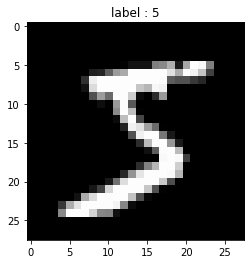

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [5]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [6]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(38400, 784)
(9600, 784)


In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [15]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, verbose = True,batch_size=20,a=0.01):
        self.verbose = verbose
        self.W1=None
        self.W2=None
        self.W3=None
        self.B1=None
        self.B2=None
        self.B3=None
        self.batch_size=batch_size
        self.Z1=None
        self.Z2=None
        self.Z3=None
        self.choice=0
        self.a=a
        pass
    def _forward(self,X):
        #第１層
        A1=np.dot(X,self.W1)+self.B1 #(20,784)*(784,400)=(20,400)
        if self.choice==1:
          self.Z1=1/(1+np.exp(-A1))
        else:
          self.Z1=np.tanh(A1)
        #第2層
        A2=np.dot(self.Z1,self.W2)+self.B2 #(20,400)*(400,200)=(20,200)

        if self.choice==1:
          self.Z2=1/(1+np.exp(-A2))
        else:
          self.Z2=np.tanh(A2)
        #第3層
        A3=np.dot(self.Z2,self.W3)+self.B3 #(20,200)*(200,10)=(20,10)
        log_z3 = np.log(np.exp(A3)) - self._logsumexp(A3) #(20,10)
        self.Z3 = np.exp(log_z3) #(20,10)
        return self.Z3
    
        #交差エントロピー関数
    def _forward_los(self,X,y):
        #self.y = self.y.reshape(-1, 1) == np.arange(10)
        self.Z3b=self._forward(X)
        #L = -(y * self.Z3b).mean(axis=0).sum()
        L=-np.sum(np.sum(y*np.log(self.Z3b),axis=1),axis=0)/self.batch_size #(20,10)*(20,10)→(1,10)→(1,1)
        return L
    def _backword(self,X,y):
        #3層目
        
        dA3=(self.Z3-y)/self.batch_size #(20,10)-(20,10)=(20,10)
        dB3=np.sum(dA3,axis=0) #(1,10)
        dW3=np.dot(self.Z2.T,dA3) #(200,20)*(20,10)=(200,10)
        dZ2=np.dot(dA3,self.W3.T) #(20,10)*(10,200)=(20,200)

        #2層目
        if self.choice==1:
          pass
        else:
          dA2=dZ2*(1-self.Z2**2) #(20,200)*(20,200)=(20,200)
        dB2=np.sum(dA2,axis=0) #(1,200)
        dW2=np.dot(self.Z1.T,dA2) #(400,20)*(20,200)=(400,200)
        dZ1=np.dot(dA2,self.W2.T) #(20,200)*(200,400)=(20,400)

        #1層目
        if self.choice==1:
          pass
        else:
          dA1=dZ1*(1-self.Z1**2) #(20,400)*(20,400)=(20,400)
        dB1=np.sum(dA1,axis=0) #(1,400)
        dW1=np.dot(X.T,dA1) #(784,20)*(20,400)=(784,400)

        #重みの更新
        self.W3=self.W3-self.a*dW3
        self.W2=self.W2-self.a*dW2
        self.W1=self.W1-self.a*dW1
        self.B3=self.B3-self.a*dB3
        self.B2=self.B2-self.a*dB2
        self.B1=self.B1-self.a*dB1
        
    def _logsumexp(self,A3):
        xmax = np.max(A3,axis=1)
        xmax=xmax.reshape(A3.shape[0],1)
        return np.log(np.exp(A3 - xmax).sum(axis=1, keepdims=True)) + xmax

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        #問1:重みの初期値
        n_features = 784
        n_nodes1 = 400
        n_nodes2=200
        n_nodes3=10
        sigma = 0.01 # ガウス分布の標準偏差
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)# W1: (784, 400)
        self.W2 = sigma * np.random.randn(n_nodes1,n_nodes2)# W2: (400, 200)
        self.W3 = sigma * np.random.randn(n_nodes2,n_nodes3)# W2: (200, 10)

        #バイアス項の初期値
        self.B1=sigma * np.random.randn(n_nodes1,)
        self.B2=sigma * np.random.randn(n_nodes2,)
        self.B3=sigma * np.random.randn(n_nodes3,)
        self.X=X
        self.y=y
        n_epochs = 5
        #n_step_iteration_report = 500
        plot_data = []
        #get_mini_batch = GetMiniBatch(self.X, self.y, self.batch_size)
        Loss=[]
        Epoch=[]
        for epoch in range(n_epochs):
            sum_of_loss = 0
            for i, (x, y) in enumerate(GetMiniBatch(self.X, self.y, self.batch_size)):
                y = y.reshape(-1, 1) == np.arange(10)
                y=y.reshape(y.shape[0],10)
                loss= self._forward_los(x, y)
                self._backword(x,y)
            Loss.append(loss)
            Epoch.append(epoch)

        plt.plot(Epoch, Loss, color='r', label='train_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        return self._forward(X).argmax(axis=1)



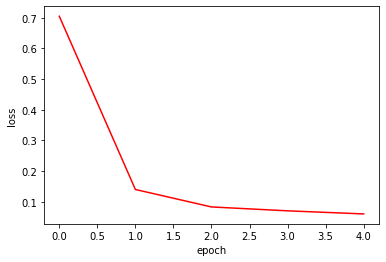

In [16]:
NN=ScratchSimpleNeuralNetrowkClassifier()
NN.fit(X_train,y_train)

In [20]:
print(X_val.shape)
y_pred=NN.predict(X_val)
print(y_pred)
print(y_pred.shape)

(9600, 784)
[8 9 1 ... 1 0 2]
(9600,)


In [21]:
#Accuracy
from sklearn.metrics import accuracy_score
#スクラッチ
print(accuracy_score(y_val, y_pred))

0.9073958333333333
